<a href="https://colab.research.google.com/github/paulxdillon/Chem-Eng/blob/master/AcetontrileWaterVLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VLE for Acetonitrile Water mixure

[[0.     0.4687 0.1   ]
 [0.4687 0.     0.3022]
 [0.1    0.3022 0.    ]]



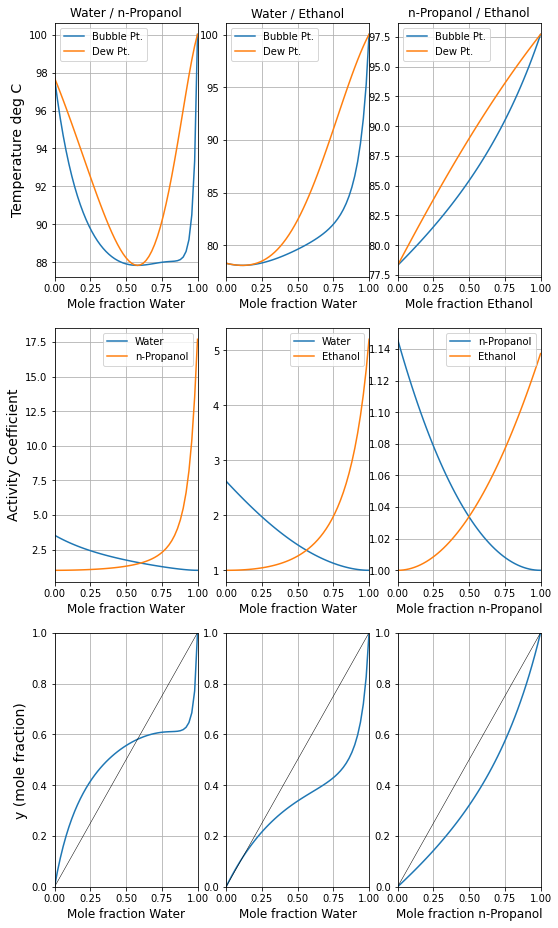

In [12]:
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
from matplotlib.lines import Line2D
from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.integrate import odeint
# from scipy.interpolate import interp1d
# import scipy as sp
from scipy.integrate import ode
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

Components = ['Water', 'n-Propanol', 'Ethanol']
Pairs = ['Water/n-Propanol', 'Water/Ethanol', 'n-Propanol/Ethanol']

TBub = [[],[],[]]
TDew = [[],[],[]]
gam1List = [[],[],[]]
gam2List = [[],[],[]]
gam3List = [[],[],[]]
Tguess = 85.0
y = [[],[],[]]

def nrtl(alpha, tau, T, x):
    tau[0, 0] = 0
    tau[0, 1] = a12 + b12 / ( T )
    tau[0, 2] = a13 + b13 / ( T )
    tau[1, 0] = a21 + b21 / ( T )
    tau[1, 1] = 0
    tau[1, 2] = a23 + b23 / ( T )
    tau[2, 0] = a31 + b31 / ( T )
    tau[2, 1] = a32 + b32 / ( T )
    tau[2, 2] = 0
    G = np.exp(-alpha * tau)
    ncomp = x.shape[0]
    gamma = np.zeros_like(x)

    for i in range(ncomp):
        summ = 0
        for j in range(ncomp):
            summ += x[j] * G[i, j] / np.sum(G[:, j] * x) * (
                        tau[i, j] - (np.sum(x * tau[:, j] * G[:, j]) / np.sum(G[:, j] * x)))
        gamma[i] = np.sum(tau[:, i] * G[:, i] * x) / np.sum(G[:, i] * x) + summ

    if np.isinf(gamma[0]):
        print("Gamm is finite ...")

    return np.exp(gamma)
Psat = dict()
Psat['Ethanol']       = lambda T: np.exp(61.7911 +
                                       (-7122.3)/(T + 0.0) +
                                       0.0*(T) +
                                       (-7.1424)*np.log(T) +
                                       2.8853E-6*(T)**2.0 )

Psat['Methanol']       = lambda T: np.exp(71.2051 +
                                       (-6904.5)/(T + 0.0) +
                                       0.0*(T) +
                                       (-8.8622)*np.log(T) +
                                       7.466e-06*(T)**2.0 )

Psat['IPA']             = lambda T: np.exp(99.2071 +
                                       (-9040)/(T + 0.0) +
                                       0.0*(T) +
                                       (-12.676)*np.log(T) +
                                       5.538e-06*(T)**2.0 )


Psat['Ethac']       = lambda T: np.exp(55.3111 +
                                       (-6227.6)/(T + 0.0) +
                                       0.0*(T) +
                                       (-6.41)*np.log(T) +
                                       1.7914E-17*(T)**1.0 )

Psat['Acetic']       = lambda T: np.exp(41.7571 +
                                       (-6304.5)/(T + 0.0) +
                                       0.0*(T) +
                                       (-4.2985)*np.log(T) +
                                       8.8865E-18*(T)**1.0 )

Psat['Water']       = lambda T: np.exp(62.1361 +
                                       (-7258.2)/(T + 0.0) +
                                       0.0*(T) +
                                       (-7.3037)*np.log(T) +
                                       4.1653e-06*(T)**2.0 )

Psat['Acetone']       = lambda T: np.exp(57.4931 +
                                       (-5599.6)/(T + 0.0) +
                                       0.0*(T) +
                                       (-7.0985)*np.log(T) +
                                       6.22e-06*(T)**2.0 )

Psat['Chloroform']       = lambda T: np.exp(134.917 +
                                       (-7792.3)/(T + 0.0) +
                                       0.0*(T) +
                                       (-20.614)*np.log(T) +
                                       0.024578*(T)**1.0 )

Psat['n-Propanol']       = lambda T: np.exp(73.1511 +
                                       (-8307.2)/(T + 0.0) +
                                       0.0*(T) +
                                       (-8.5767)*np.log(T) +
                                       7.5091E-18*(T)**1.0 )

def bubblePt(x, T, P):
    tau[0, 0] = 0
    tau[0, 1] = a12 + b12 / ( T )
    tau[0, 2] = a13 + b13 / ( T )
    tau[1, 0] = a21 + b21 / ( T )
    tau[1, 1] = 0
    tau[1, 2] = a23 + b23 / ( T )
    tau[2, 0] = a31 + b31 / ( T )
    tau[2, 1] = a32 + b32 / ( T )
    tau[2, 2] = 0
    [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(x))
    if np.isnan(tau).any():
        print("Tau is NAN ...")

    f = P - x[0] * gam1 * Psat[Components[0]](T) - x[1] * gam2 * Psat[Components[1]](T) - x[2] * gam3 * Psat[Components[2]](T)
    return f

def dewPt(y, T, P):
    tau[0, 1] = a12 + b12 / (T + 273.15)
    tau[0, 2] = a13 + b13 / (T + 273.15)
    tau[1, 0] = a21 + b21 / (T + 273.15)
    tau[1, 2] = a23 + b23 / (T + 273.15)
    tau[2, 0] = a31 + b31 / (T + 273.15)
    tau[2, 1] = a32 + b32 / (T + 273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(y))

    f = P - 1 / (y[0] / (gam1 * Psat[Components[0]](T)) + y[1] / (gam2 * Psat[Components[1]](T)) + y[2] / (
                gam3 * Psat[Components[2]](T)))
    return f


a12 = 0
a21 = 0
a13 = 3.9083
a31 = -1.12
a23 = 0
a32 = 0

b12 = 927.975
b21 = 181.216

b13 = -304.265
b31 = -56.6118

b23 = 20.26
b32 = 28.0194

c12 = 0.4687
c21 = 0.4687
c13 = 0.1
c31 = 0.1
c23 = 0.3022
c32 = 0.3022

ncomp = 3
tau = np.ndarray((ncomp, ncomp), float)
alpha = np.ndarray((ncomp, ncomp), float)

alpha = np.ndarray((3, 3), float)

alpha[0, 0] = 0;     alpha[0, 1] = c12;     alpha[0, 2] = c13
alpha[1, 0] = c12;   alpha[1, 1] = 0;       alpha[1, 2] = c23
alpha[2, 0] = c13;   alpha[2, 1] = c23;     alpha[2, 2] = 0;

T = 60 


print(alpha)
plotTxy = 1

if plotTxy:
    x = np.linspace(0, 1, 51).tolist()
    Tguess = 320
    P = 1.01325
    # Pair 1-2
    for xFrac in x:
        Tbubble, = fsolve(lambda T: bubblePt([xFrac, 1 - xFrac, 0], T, P), Tguess, xtol=1e-12)
        Tdew, = fsolve(lambda T: dewPt([xFrac, 1 - xFrac, 0], T, P), Tguess, xtol=1e-12)
        TDew[0].append(Tdew)
        TBub[0].append(Tbubble)

        # tau[0, 1] = a12 + b12 / (Tbubble )
        # tau[0, 2] = a13 + b13 / (Tbubble )
        # tau[1, 0] = a21 + b21 / (Tbubble)
        # tau[1, 2] = a23 + b23 / (Tbubble )
        # tau[2, 0] = a31 + b31 / (Tbubble )
        # tau[2, 1] = a32 + b32 / (Tbubble )
        [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([xFrac, 1 - xFrac, 0]))

        y1 = xFrac * gam1 * Psat[Components[0]](Tbubble) / P
        y[0].append(y1)

        gam1List[0].append(gam1)
        gam2List[0].append(gam2)

    # Pair 1-3
    for xFrac in x:
        Tbubble, = fsolve(lambda T: bubblePt([xFrac, 0, 1 - xFrac], T, P), Tguess, xtol=1e-12)
        Tdew, = fsolve(lambda T: dewPt([xFrac, 0, 1 - xFrac], T, P), Tguess, xtol=1e-12)
        TDew[1].append(Tdew)
        TBub[1].append(Tbubble)

        # tau[0, 1] = a12 + b12 / (Tbubble + 273.15)
        # tau[0, 2] = a13 + b13 / (Tbubble + 273.15)
        # tau[1, 0] = a21 + b21 / (Tbubble + 273.15)
        # tau[1, 2] = a23 + b23 / (Tbubble + 273.15)
        # tau[2, 0] = a31 + b31 / (Tbubble + 273.15)
        # tau[2, 1] = a32 + b32 / (Tbubble + 273.15)
        [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([xFrac, 0, 1 - xFrac]))

        y1 = xFrac * gam1 * Psat[Components[0]](Tbubble) / P
        y[1].append(y1)

        gam1List[1].append(gam1)
        gam3List[0].append(gam3)

    # Pair 2-3
    for xFrac in x:
        Tbubble, = fsolve(lambda T: bubblePt([0, xFrac, 1 - xFrac], T, P), Tguess, xtol=1e-12)
        Tdew, = fsolve(lambda T: dewPt([0, xFrac, 1 - xFrac], T, P), Tguess, xtol=1e-12)
        TDew[2].append(Tdew)
        TBub[2].append(Tbubble)

        # tau[0, 1] = a12 + b12 / (Tbubble + 273.15)
        # tau[0, 2] = a13 + b13 / (Tbubble + 273.15)
        # tau[1, 0] = a21 + b21 / (Tbubble + 273.15)
        # tau[1, 2] = a23 + b23 / (Tbubble + 273.15)
        # tau[2, 0] = a31 + b31 / (Tbubble + 273.15)
        # tau[2, 1] = a32 + b32 / (Tbubble + 273.15)
        [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([0, xFrac, 1 - xFrac]))

        y1 = xFrac * gam2 * Psat[Components[1]](Tbubble) / P
        y[2].append(y1)

        gam2List[1].append(gam2)
        gam3List[1].append(gam3)

    plt1.figure(figsize=(10, 15))
    print()

    # Plot T-xy
    # =========
    plt1.subplot(3, 3, 1)
    plt1.plot(x, [x - 273.15 for x in TBub[0]], x, [x - 273.15 for x in TDew[0]])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    plt1.ylabel('Temperature deg C', fontsize=14)
    plt1.title(Components[0] + ' / ' + Components[1], fontsize=12)
    plt1.legend(['Bubble Pt.', 'Dew Pt.'], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    plt1.subplot(3, 3, 2)
    plt1.plot(x, [x - 273.15 for x in TBub[1]], x, [x - 273.15 for x in TDew[1]])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    # plt1.ylabel('Temperature deg C', fontsize=14)
    plt1.title(Components[0] + ' / ' + Components[2], fontsize=12)
    plt1.legend(['Bubble Pt.', 'Dew Pt.'], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    plt1.subplot(3, 3, 3)
    plt1.plot(x, [x - 273.15 for x in TBub[2]], x, [x - 273.15 for x in TDew[2]])
    plt1.xlabel('Mole fraction ' + Components[2], fontsize=12)
    # plt1.ylabel('Temperature deg C', fontsize=14)
    plt1.title(Components[1] + ' / ' + Components[2], fontsize=12)
    plt1.legend(['Bubble Pt.', 'Dew Pt.'], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    # Plot Activity Coefficients (NRTL model)
    # =======================================
    plt1.subplot(3, 3, 4)
    plt1.plot(x, gam1List[0], x, gam2List[0])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    plt1.ylabel('Activity Coefficient', fontsize=14)
    # plt1.title( Components[0] + ' / ' + Components[1], fontsize=12 )
    plt1.legend([Components[0], Components[1]], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    plt1.subplot(3, 3, 5)
    plt1.plot(x, gam1List[1], x, gam3List[0])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    plt1.legend([Components[0], Components[2]], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    plt1.subplot(3, 3, 6)
    plt1.plot(x, gam2List[1], x, gam3List[1])
    plt1.xlabel('Mole fraction ' + Components[1], fontsize=12)
    plt1.legend([Components[1], Components[2]], fontsize=10)
    plt1.grid()
    plt1.xlim(0, 1)

    # Plot y vs x
    # ============
    plt1.subplot(3, 3, 7)
    plt1.plot(x, y[0])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    plt1.ylabel('y (mole fraction)', fontsize=14)
    plt1.grid()
    plt1.xlim(0, 1)
    plt1.ylim(0, 1)
    plt1.yticks(np.linspace(0, 1.0, 6))
    plt1.plot([1, 0, ], [1, 0], '-k', linewidth=.5)

    plt1.subplot(3, 3, 8)
    plt1.plot(x, y[1])
    plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
    plt1.grid()
    plt1.xlim(0, 1)
    plt1.ylim(0, 1)
    plt1.yticks(np.linspace(0, 1.0, 6))
    plt1.plot([1, 0, ], [1, 0], '-k', linewidth=.5)

    plt1.subplot(3, 3, 9)
    plt1.plot(x, y[2])
    plt1.xlabel('Mole fraction ' + Components[1], fontsize=12)
    plt1.grid()
    plt1.xlim(0, 1)
    plt1.ylim(0, 1)
    plt1.yticks(np.linspace(0, 1.0, 6))
    plt1.plot([1, 0, ], [1, 0], '-k', linewidth=.5)

    plt1.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    plt1.tight_layout
    plt1.show()